In [1]:
!python -m pip install -qq kaggle

In [2]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download trolukovich/food11-image-dataset
unzip -qq '/content/food11-image-dataset.zip'
mv "evaluation" "test"
mv "training" "train"
mv "validation" "valid"

100%|██████████| 1.08G/1.08G [00:11<00:00, 104MB/s]


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import matplotlib.pyplot as plt
import glob

In [4]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(299,299),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('valid',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(299,299),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(299,299),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

Found 9866 files belonging to 11 classes.
Using 6907 files for training.
Found 3430 files belonging to 11 classes.
Using 1029 files for validation.
Found 3347 files belonging to 11 classes.
Total training images: tf.Tensor(6912, shape=(), dtype=int64)
Total validation images: tf.Tensor(1056, shape=(), dtype=int64)
Total test images: tf.Tensor(3360, shape=(), dtype=int64)
Class names: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


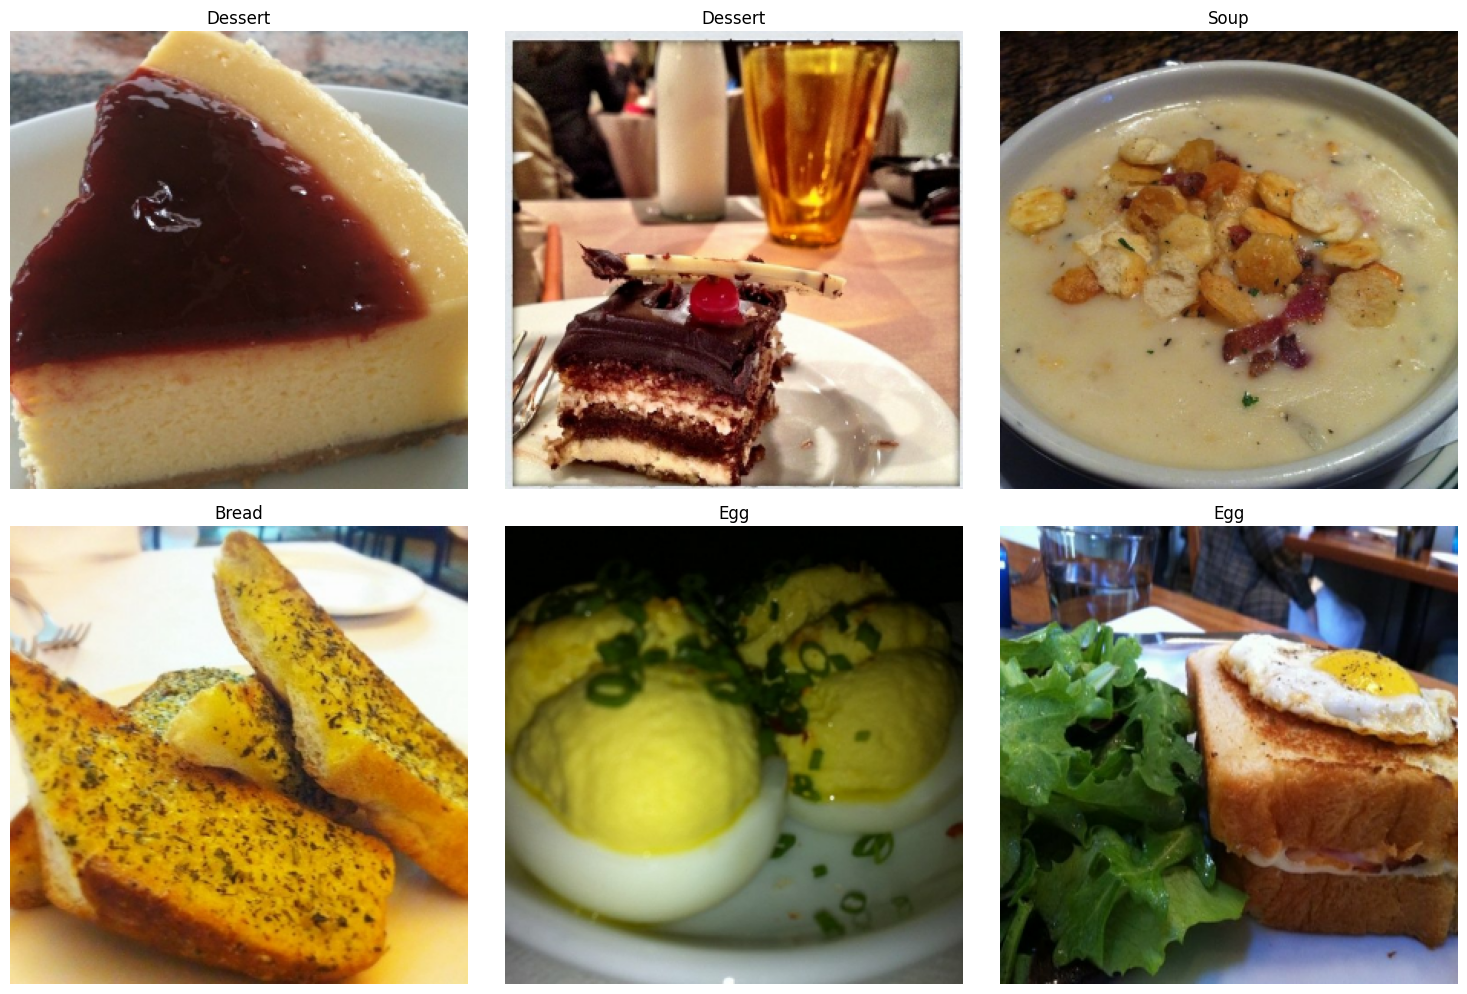

In [5]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [6]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [7]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation

In [8]:
base_model=tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=(299,299,3))  # laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False

83683744/83683744 [==============================] - 1s 0us/step


In [9]:
inputs=tf.keras.layers.Input(shape=(299,299,3),batch_size=None,name='model_inputs')                                 # add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)                                         # rescale inputs
model_x=base_model(model_x)                                                                                         # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                                                            # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                                                      # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)                                  # output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_exception')                                         # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None) # print model summary

Model: "custom_exception"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 299, 299, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 299, 299, 3)                             0                 Y          
                                                                                                                                   
 xception (Functional)                                (None, 10, 10, 2048)                            20861480          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [10]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [11]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
216/216 - 91s - loss: 3.6732 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.6896 - val_sparse_categorical_accuracy: 0.8134 - 91s/epoch - 420ms/step
Epoch 2/10000
216/216 - 70s - loss: 0.2600 - sparse_categorical_accuracy: 0.9220 - val_loss: 0.7391 - val_sparse_categorical_accuracy: 0.8086 - 70s/epoch - 324ms/step
Epoch 3/10000
216/216 - 70s - loss: 0.1074 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.7850 - val_sparse_categorical_accuracy: 0.8280 - 70s/epoch - 326ms/step
Epoch 4/10000
216/216 - 71s - loss: 0.0535 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.7803 - val_sparse_categorical_accuracy: 0.8290 - 71s/epoch - 327ms/step
Epoch 5/10000
216/216 - 72s - loss: 0.0536 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.8367 - 72s/epoch - 332ms/step
Epoch 6/10000
216/216 - 69s - loss: 0.0649 - sparse_categorical_accuracy: 0.9786 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.8222 - 69s/epoch - 321ms/ste

In [12]:
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,3.673203,0.747792,0.689632,0.813411
1,0.260032,0.921963,0.739142,0.808552
2,0.107359,0.966266,0.785001,0.827988
3,0.053482,0.980744,0.780284,0.828960
4,0.053606,0.982482,0.868368,0.836735


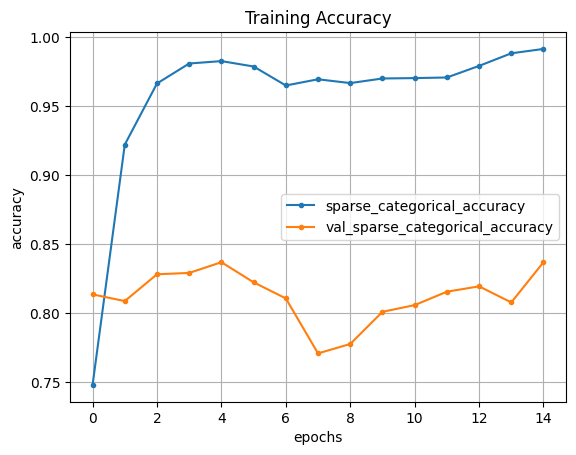

In [13]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()

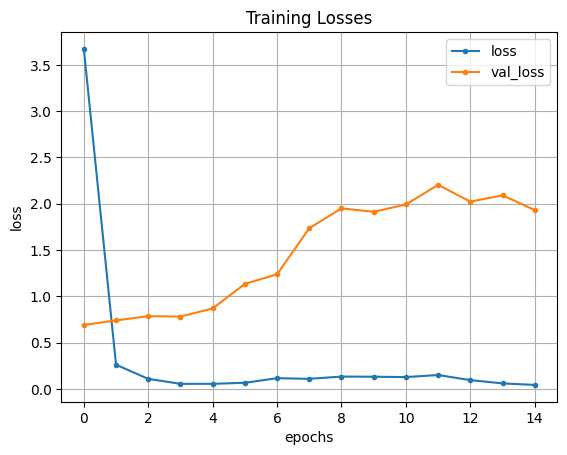

In [14]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()

In [15]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

105/105 [==============================] - 28s 265ms/step - loss: 0.6858 - sparse_categorical_accuracy: 0.8647
Testing results: {'loss': 0.6857576370239258, 'sparse_categorical_accuracy': 0.8646548986434937}


In [16]:
# make save model (weights and configuration)
model.save('food_Xception',overwrite=True,save_format=None)                     # make save

In [ ]:
!zip -r -qq "food_Xception.zip" "food_Xception"                                 # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('food_Xception.zip')                                             # download model zip file